# LEV / GSW overlay

Various methods for overlaying emergent lake vegetation rasters over Pekel/GSW inundation rasters. Occurrence seems to perform better than Seasonality.

In [1]:
## Imports
import os
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
from scipy.stats import binned_statistic
import seaborn as sns
from tqdm import tqdm
import numpy as np
import pandas as pd

In [2]:
## Env vars
reclass_vals_detailed = {
    1:	'dry land',
    2:	'water',
    3:	'wet graminoid',
    4:	'wet shrubs',
    5:	'wet forest',
    25: 'river or bridge',
    30: 'urban',
    35: 'non-roi',
    42:	'water no lake',
    43:	'wet graminoid no lake',
    44: 'wet shrubs no lake',
    45: 'wet forest no lake',
    52: 'water not valid'}

reclass_vals_simple = {
    1:	'dry land',
    2:	'water',
    3:	'LEV',
    4:	'LEV',
    5:	'LEV',
    25: 'invalid', 
    30: 'invalid', 
    35: 'non-roi', 
    42:	'invalid', 
    43:	'invalid', 
    44: 'invalid', 
    45: 'invalid', 
    52: 'invalid'}

## Load from GIS operations
In QGIS:
1. Polygonize burned UAVSAR raster
2. Zonal histogram based on DN field

In Python:
1. Aggregate by class
2. Compute confusion matrix and plot histograms

In [4]:
## I/O
region = 'YF-validation'
df_pth = '/Volumes/thebe/Ch4/misc/UAVSAR_polygonized/sub_roi/zonal_hist/v2_5m_bic/YFLATS_190914_mosaic_rcls_brn_zHist_Oc_train.shp' # this is zonal histogram of YF UAVSAR against GSW Occurrence
# region = 'CSB'
# df_pth = '/Volumes/thebe/Ch4/misc/UAVSAR_polygonized/sub_roi/zonal_hist/v2_5m_bic/bakerc_16008_19059_012_190904_L090_CX_01_Freeman-inc_rcls_brn_zHist_Oc.shp'
# region = 'PAD'
# df_pth = '/Volumes/thebe/Ch4/misc/UAVSAR_polygonized/sub_roi/zonal_hist/v2_5m_bic/padelE_36000_19059_003_190904_L090_CX_01_Freeman-inc_rcls_brn_zHist_Oc.shp'
# region = 'CSD'
# df_pth = '/Volumes/thebe/Ch4/misc/UAVSAR_polygonized/sub_roi/zonal_hist/v2_5m_bic/daring_21405_17094_010_170909_L090_CX_01_LUT-Freeman_rcls_brn_zHist_Oc.shp'

## Outputs
overlay_pth = os.path.join(os.path.dirname(df_pth), 'LEV_GSW_overlay', os.path.basename(df_pth).replace('.shp', '_LEV.csv'))## Load
overlay_pth_s = os.path.join(os.path.dirname(df_pth), 'LEV_GSW_overlay', os.path.basename(df_pth).replace('.shp', '_LEV_s.csv'))## Load

df = gpd.read_file(df_pth, engine='pyogrio') 
df.head()

,DN,HISTO_0,HISTO_1,HISTO_2,HISTO_3,HISTO_4,HISTO_5,HISTO_6,HISTO_7,HISTO_8,...,HISTO_105,HISTO_106,HISTO_107,HISTO_108,HISTO_109,HISTO_110,HISTO_111,HISTO_112,id,geometry
0,35,712.0,102.0,68.0,33.0,25.0,19.0,22.0,19.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,"POLYGON ((-2014559.681 3746618.675, -2014559.6..."
1,35,948.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,"POLYGON ((-2044475.097 3746528.330, -2044475.0..."
2,35,835.0,21.0,13.0,14.0,12.0,11.0,13.0,9.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,"POLYGON ((-2044706.606 3746325.055, -2044706.6..."
3,35,756.0,8.0,14.0,8.0,8.0,10.0,3.0,6.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,"POLYGON ((-2041905.917 3746274.236, -2041905.9..."
4,35,1157.0,10.0,7.0,4.0,4.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,"POLYGON ((-2039534.367 3746206.477, -2039534.3..."


In [5]:
## Add actual class name
df['Class'] = df['DN'].apply(lambda x: reclass_vals_detailed[x])
df['Broad_class'] = df['DN'].apply(lambda x: reclass_vals_simple[x])

In [6]:
# Aggregate by class (detailed)
dfg = df.groupby('Class')
df_sums = dfg.sum(numeric_only=True)
df_sums.drop(columns='DN', inplace=True) # drop meaningless columns
df_sums.loc['SUM', :]=df_sums.sum() # won't actually use this if normalizing by lake area

# Aggregate by class (simple)
dfgs = df.groupby('Broad_class')
df_sums_s = dfgs.sum(numeric_only=True)
df_sums_s.drop(columns='DN', inplace=True)
df_sums_s.drop(index='non-roi', inplace=True)
df_sums_s.loc['SUM', :]=df_sums_s.sum() # don't include out of ROI samples, obviously


## Save array
df_sums.to_csv(overlay_pth)
df_sums_s.to_csv(overlay_pth_s)

## View
df_sums_s

,HISTO_0,HISTO_1,HISTO_2,HISTO_3,HISTO_4,HISTO_5,HISTO_6,HISTO_7,HISTO_8,HISTO_9,...,HISTO_104,HISTO_105,HISTO_106,HISTO_107,HISTO_108,HISTO_109,HISTO_110,HISTO_111,HISTO_112,id
Broad_class,,,,,,,,,,,,,,,,,,,,,
LEV,586434.0,33771.0,28178.0,25089.0,21252.0,18599.0,17791.0,16009.0,14637.0,13475.0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,162894.0
dry land,54836184.0,174583.0,137944.0,117984.0,86803.0,66815.0,55470.0,46434.0,40695.0,36396.0,...,69.0,42.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,94692.0
invalid,3207567.0,77059.0,58892.0,49028.0,40675.0,35564.0,31762.0,29610.0,28347.0,26923.0,...,2166.0,1160.0,553.0,244.0,87.0,44.0,7.0,7.0,1.0,220653.0
water,867708.0,33030.0,32455.0,29789.0,24857.0,21856.0,19572.0,18211.0,17487.0,16342.0,...,123.0,59.0,26.0,9.0,2.0,0.0,0.0,0.0,0.0,79314.0
SUM,59497893.0,318443.0,257469.0,221890.0,173587.0,142834.0,124595.0,110264.0,101166.0,93136.0,...,2358.0,1263.0,593.0,254.0,89.0,44.0,7.0,7.0,1.0,557553.0


In [7]:
## Compute mean LEV, regardless of Occurrence
sums = df_sums_s.sum(axis=1)
print(f'Region: {region}')
print(f"Landscape fraction: {sums.LEV / (sums.LEV + sums['dry land'] + sums.water):2.2%}")
print(f"Lake fraction: {sums.LEV / (sums.LEV + sums.water):2.2%}")

Region: YF
Landscape fraction: 2.09%
Lake fraction: 22.05%


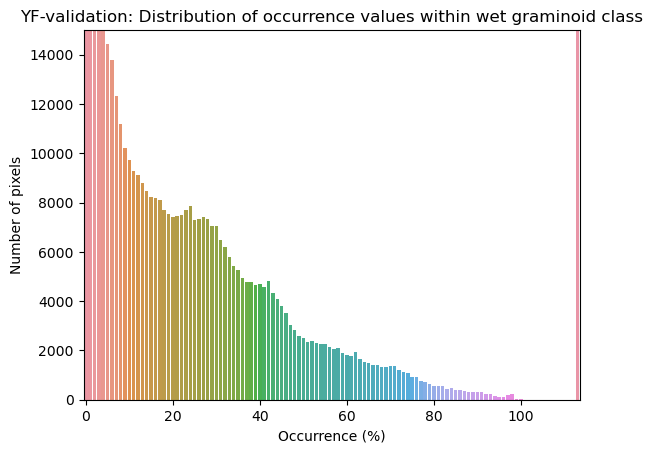

In [10]:
## Plot hist to show: "Within all wet graminoid pixels, what was the distribution of occurrence values"
'''Almost all WG pixels have 0 occurrence...'''
hist_wg = df_sums.loc['wet graminoid', 'HISTO_0':] # 'HISTO_100'
sns.barplot(x=np.arange(df_sums.columns.size), y=hist_wg)
plt.ylim([0, 15000])
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence (%)')
plt.ylabel('Number of pixels')
plt.title(f'{region}: Distribution of occurrence values within wet graminoid class')
plt.show()

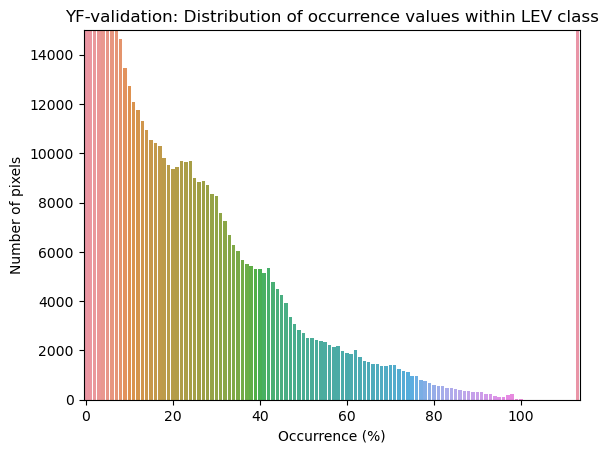

In [11]:
## Plot hist to show: "Within all LEV, what was the distribution of occurrence values"
'''Almost all WG pixels have 0 occurrence...'''
hist_wg = df_sums_s.loc['LEV', 'HISTO_0':]
sns.barplot(x=np.arange(df_sums.columns.size), y=hist_wg)
plt.ylim([0, 15000]) #5,000 for most sites, 10,000 for PAD
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence (%)')
plt.ylabel('Number of pixels')
plt.title(f'{region}: Distribution of occurrence values within LEV class')
plt.show()

### Now, group occurrence and calculate confusion matrix

In [12]:
## Compute binned statistic
stats_classes = ['LEV', 'dry land', 'water', 'SUM'] # 
bStat = binned_statistic(np.arange(df_sums_s.columns.size), values=df_sums_s.loc[stats_classes, :], statistic='sum', bins=[0, 5, 50, 95, 100]) # 
df_sums_s
bStat


BinnedStatisticResult(statistic=array([[6.9472400e+05, 3.8815700e+05, 5.5787000e+04, 6.7200000e+02],
       [5.5353498e+07, 8.3652900e+05, 1.0964600e+05, 8.3721000e+04],
       [9.8783900e+05, 9.9550500e+05, 2.2155870e+06, 3.2317400e+05],
       [6.0469282e+07, 3.0696920e+06, 3.2562770e+06, 1.8014050e+06]]), bin_edges=array([  0.,   5.,  50.,  95., 100.]), binnumber=array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5]))

In [13]:
## Construct Confusion Matrix

cm = pd.DataFrame(bStat.statistic[[0, -1]], columns = bStat.bin_edges[1:], index = [stats_classes[0], stats_classes[-1]])
cm.loc['Other', :] = cm.loc['SUM',:] - cm.loc['LEV', :] # this will return an error if the row order or names changes
cm = cm.reindex(cm.index[[0,2,1]])
cm

## Construct Confusion Matrix with water
cm_full = pd.DataFrame(bStat.statistic, columns = bStat.bin_edges[1:], index = stats_classes)
cm_full.loc['Other', :] = cm_full.loc['SUM',:] - cm_full.loc[stats_classes[:3], :].sum()
cm_full = cm_full.reindex(cm_full.index[[0,1,2,4,3]])
cm_full

,5.0,50.0,95.0,100.0
LEV,694724.0,388157.0,55787.0,672.0
dry land,55353498.0,836529.0,109646.0,83721.0
water,987839.0,995505.0,2215587.0,323174.0
Other,3433221.0,849501.0,875257.0,1393838.0
SUM,60469282.0,3069692.0,3256277.0,1801405.0


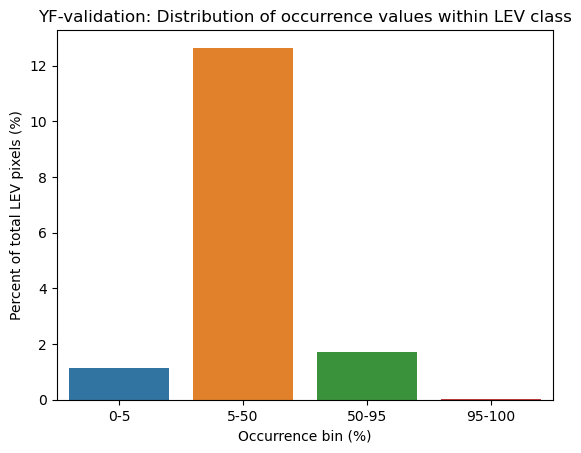

In [15]:
## Plot binned stat
## Plot hist to show: "Within all LEV, what was the binned distribution of occurrence values (normalized by total pixels in each LEV bin, so values don't sum to 100)?"
'''Almost all WG pixels have 0 occurrence...'''
bin_labels = ['0-5', '5-50', '50-95', '95-100']
sns.barplot(x=cm.columns, y=cm.loc['LEV', :] / cm.loc['SUM', :] * 100)

# plt.ylim([0, 5000])
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence bin (%)')
plt.xticks(ticks=np.arange(4), labels = bin_labels)
plt.ylabel('Percent of total LEV pixels (%)')
plt.title(f'{region}: Distribution of occurrence values within LEV class')
plt.show()



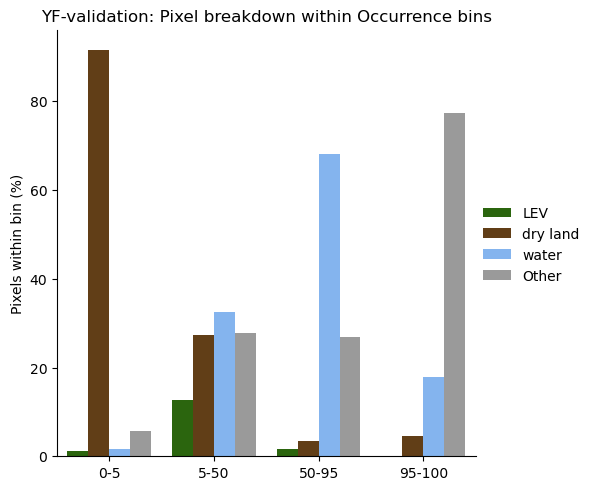

In [16]:
## Plot binned stat for all main classes as percentage of total pixels in bin (reshape first with pd.melt). Normalization is same as above plot, so each group sums to 100.
g = sns.catplot((cm_full.drop('SUM')/ cm_full.loc['SUM', :] * 100).reset_index().melt(id_vars='index', var_name='bin_R_edge'),\
     x = 'bin_R_edge', y='value', hue='index', kind='bar', palette=['#267300', '#6d3f0b', '#73b2ff', '#9a9a9a']) #
g.legend.set_title('')
g.set_axis_labels('', 'Pixels within bin (%)')
g.set(title=f'{region}: Pixel breakdown within Occurrence bins', xticklabels=bin_labels)

### Bar plots grouped and normalized the opposite way

In [17]:
## Add sum column
cm_full.columns = cm_full.columns.astype('str')
cm_full['ROWSUM'] = cm_full.sum(axis='columns')

# Rename labels
cm_full.columns=bin_labels + ['ROWSUM']

## Normalize by dividing row by sum
cm_full_rowNorm = pd.DataFrame(cm_full.values / cm_full.loc[:,'ROWSUM':].values * 100, index=cm_full.index, columns=cm_full.columns)# .drop('SUM')
cm_full_rowNorm

,0-5,5-50,50-95,95-100,ROWSUM
LEV,60.976004,34.068584,4.896431,0.058982,100.0
dry land,98.173405,1.483644,0.194465,0.148485,100.0
water,21.844672,22.014195,48.994594,7.146539,100.0
Other,52.401051,12.965884,13.358996,21.274068,100.0
SUM,88.151938,4.474988,4.746991,2.626083,100.0


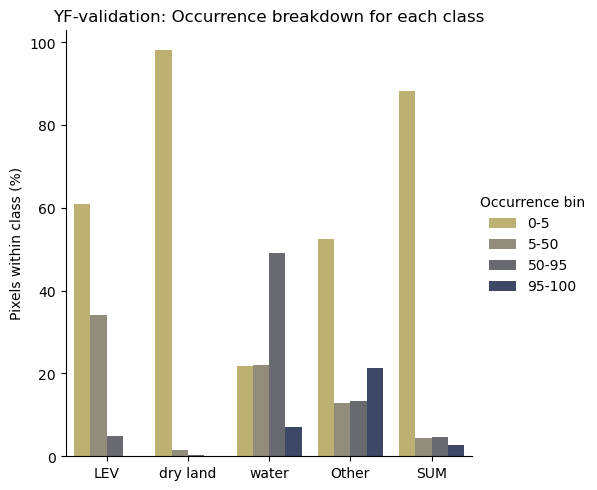

In [18]:
## Reshape (melt) and plot as grouped bar plot
"Within all of one occurrence bin, what was the contribution of LEV values"
g = sns.catplot(cm_full_rowNorm.drop(columns='ROWSUM').reset_index().melt(id_vars='index', var_name='Occurrence bin'),\
     hue = 'Occurrence bin', y='value', x='index', kind='bar', palette='cividis_r')
g.set_axis_labels('', 'Pixels within class (%)')
g.set(title=f'{region}: Occurrence breakdown for each class')

### Compare to holdout ds

In [35]:
## I/O
region = 'YF holdout'
df_pth = '/Volumes/thebe/Ch4/misc/UAVSAR_polygonized/sub_roi/zonal_hist/v2_5m_bic/YF_train_holdout/zonal_hist_w_UAVSAR/YFLATS_190914_mosaic_rcls_brn_zHist_UAV_holdout.shp' # this is zonal histogram of YF UAVSAR against GSW Occurrence

df = gpd.read_file(df_pth, engine='pyogrio') 
df.head()

,Hylak_id,Lake_name,Country,Continent,Poly_src,Lake_type,Grand_id,Lake_area,Shore_len,Shore_dev,...,HISTO_2,HISTO_3,HISTO_4,HISTO_5,HISTO_25,HISTO_42,HISTO_43,HISTO_44,HISTO_45,geometry
0,34437,None,United States of America,North America,NHD,1,0,1.04,6.53,1.81,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-145.81440 66.89782, -145.81366 66.8..."
1,34546,None,United States of America,North America,NHD,1,0,1.25,5.67,1.43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-145.78034 66.87963, -145.77895 66.8..."
2,34698,None,United States of America,North America,NHD,1,0,1.08,5.25,1.42,...,22101.0,9592.0,72.0,0.0,0.0,1.0,46.0,0.0,0.0,"POLYGON ((-145.09640 66.82440, -145.09292 66.8..."
3,34768,None,United States of America,North America,NHD,1,0,2.14,6.78,1.31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-145.65421 66.81972, -145.65553 66.8..."
4,34774,None,United States of America,North America,NHD,1,0,1.06,4.19,1.15,...,13638.0,2956.0,76.0,0.0,0.0,16.0,443.0,22.0,0.0,"POLYGON ((-144.88561 66.80491, -144.88744 66.8..."


In [36]:
## Rename columns to show landcover percentages

reclass_vals_hist_detailed = {
    'HISTO_1':	'dry land',
    'HISTO_2':	'water',
    'HISTO_3':	'wet graminoid',
    'HISTO_4':	'wet shrubs',
    'HISTO_5':	'wet forest',
    'HISTO_25': 'river or bridge',
    'HISTO_30': 'urban',
    'HISTO_35': 'non-roi',
    'HISTO_42':	'water no lake',
    'HISTO_43':	'wet graminoid no lake',
    'HISTO_44': 'wet shrubs no lake',
    'HISTO_45': 'wet forest no lake',
    'HISTO_52': 'water not valid'}
df.drop(columns=['Lake_name', 'Country', 'Continent', 'Poly_src',
       'Lake_type', 'Grand_id', 'Shore_len', 'Shore_dev',
       'Vol_total', 'Vol_res', 'Vol_src', 'Depth_avg', 'Dis_avg', 'Res_time',
       'Elevation', 'Slope_100', 'Wshd_area', 'Pour_long', 'Pour_lat'], inplace=True) #.rename(lambda txt: txt.replace('HISTO_', ''))
df.rename(columns=reclass_vals_hist_detailed, inplace=True)
df.head()

,Hylak_id,Lake_area,HISTO_NODA,dry land,water,wet graminoid,wet shrubs,wet forest,river or bridge,water no lake,wet graminoid no lake,wet shrubs no lake,wet forest no lake,geometry
0,34437,1.04,32903.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-145.81440 66.89782, -145.81366 66.8..."
1,34546,1.25,39588.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-145.78034 66.87963, -145.77895 66.8..."
2,34698,1.08,0.0,2456.0,22101.0,9592.0,72.0,0.0,0.0,1.0,46.0,0.0,0.0,"POLYGON ((-145.09640 66.82440, -145.09292 66.8..."
3,34768,2.14,67559.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-145.65421 66.81972, -145.65553 66.8..."
4,34774,1.06,0.0,16334.0,13638.0,2956.0,76.0,0.0,0.0,16.0,443.0,22.0,0.0,"POLYGON ((-144.88561 66.80491, -144.88744 66.8..."


In [37]:
## Add wet forest if not present
if 'wet forest' not in df.columns:
    df['wet forest'] = 0.0
df['wet forest']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
229    0.0
230    0.0
231    0.0
232    0.0
233    0.0
Name: wet forest, Length: 234, dtype: float64

In [48]:
## Lev percentage TBD
df['A_LEV'] = (df['wet graminoid'] + df['wet shrubs'] + df['wet forest']) / (df['water'] + df['wet graminoid'] + df['wet shrubs'] + df['wet forest']) # Note: no wet forest present
df.query("A_LEV>=0", inplace=True) # Drop any non-observed lakes
a_lev = np.average(df.A_LEV, weights=df.Lake_area)
print(f'Measured A_LEV in holdout ds: {a_lev:0.2%}')

df_add_lev_pth = df_pth.replace('.shp', '_LEV.shp')
df.to_file(df_add_lev_pth)
print('wrote file: {df_add_lev_pth}.')

Measured A_LEV in holdout ds: 11.27%


/tmp/ipykernel_16696/3751069913.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file(df_add_lev_pth)


wrote file: {df_add_lev_pth}.


In [47]:
# How many HL lakes have LEVE detected?
np.sum(~ np.isnan(df.A_LEV))
# np.sum(~ np.isnan(df.Lake_area))

123

## Save output

In [ ]:
# Aggregate by class (detailed)
dfg = df.groupby('Class')
df_sums = dfg.sum(numeric_only=True)
df_sums.drop(columns='DN', inplace=True) # drop meaningless columns
df_sums.loc['SUM', :]=df_sums.sum() # won't actually use this if normalizing by lake area

# Aggregate by class (simple)
dfgs = df.groupby('Broad_class')
df_sums_s = dfgs.sum(numeric_only=True)
df_sums_s.drop(columns='DN', inplace=True)
df_sums_s.drop(index='non-roi', inplace=True)
df_sums_s.loc['SUM', :]=df_sums_s.sum() # don't include out of ROI samples, obviously


## Save array
df_sums.to_csv(overlay_pth)
df_sums_s.to_csv(overlay_pth_s)

## View
df_sums_s

,HISTO_0,HISTO_1,HISTO_2,HISTO_3,HISTO_4,HISTO_5,HISTO_6,HISTO_7,HISTO_8,HISTO_9,...,HISTO_103,HISTO_104,HISTO_105,HISTO_106,HISTO_107,HISTO_108,HISTO_109,HISTO_110,HISTO_111,HISTO_112
Broad_class,,,,,,,,,,,,,,,,,,,,,
LEV,451005.0,25534.0,19312.0,16219.0,14575.0,13159.0,12338.0,11508.0,10672.0,10291.0,...,44.0,21.0,8.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0
dry land,31043917.0,96499.0,65110.0,51674.0,43936.0,37966.0,33985.0,31045.0,27938.0,25731.0,...,246.0,161.0,78.0,56.0,28.0,15.0,4.0,3.0,2.0,0.0
invalid,564615.0,2683.0,1910.0,1493.0,1357.0,1155.0,1032.0,999.0,964.0,856.0,...,52.0,38.0,27.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0
water,510158.0,35569.0,29718.0,27301.0,24990.0,24046.0,22744.0,22282.0,21892.0,21136.0,...,2289.0,1089.0,426.0,181.0,90.0,35.0,21.0,7.0,2.0,1.0
SUM,32569695.0,160285.0,116050.0,96687.0,84858.0,76326.0,70099.0,65834.0,61466.0,58014.0,...,2631.0,1309.0,539.0,243.0,121.0,51.0,26.0,11.0,4.0,1.0


In [ ]:
## Compute mean LEV, regardless of Occurrence
sums = df_sums_s.sum(axis=1)
print(f'Region: {region}')
print(f"Landscape fraction: {sums.LEV / (sums.LEV + sums['dry land'] + sums.water):2.2%}")
print(f"Lake fraction: {sums.LEV / (sums.LEV + sums.water):2.2%}")

Region: CSB
Landscape fraction: 2.25%
Lake fraction: 8.20%


### Try to visualize confusion matrix

In [2]:
cm.iloc[:2, :-1]

NameError: name 'cm' is not defined

KeyError: (0, 0)

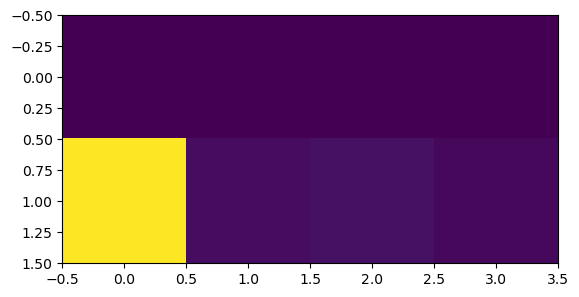

In [130]:
## Visualize CM
from sklearn.metrics import ConfusionMatrixDisplay
cmD = ConfusionMatrixDisplay(cm.iloc[:2, :])
# cmD.
cmD.plot()

### CM viz V2

In [152]:
## Add row sum
# cm.columns = ['0-5', '5-50', '50-95', '95-100'] # comment out if already run
# cm['SUM'] = cm.sum(axis=1)
cm.astype('int')

,0-5,5-50,50-95,95-100,SUM
LEV,171108,57047,14811,223,243189
SUM,50507184,1657152,2227264,1062964,55454564
Other,50336076,1600105,2212453,1062741,55211375


KeyError: (0, 0)

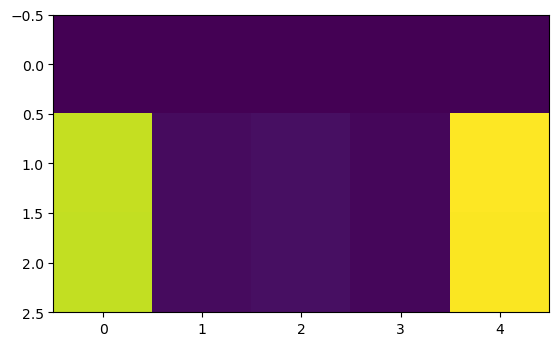

In [148]:
cmD = ConfusionMatrixDisplay(cm)
# cmD = ConfusionMatrixDisplay(cm.iloc[:2, :4])
# cmD.
cmD.plot()

# Scrap

## Method B: Load from lengthy GIS operations
In QGIS:
1. Polygonize burned UAVSAR raster
2. Dissolve based on DN field to get only n entries corresponding to n classes
2. Zonal histogram based on DN field

In [30]:
## Load file that has already been aggregated through verrry slow QGIS dissolve by DN
df = gpd.read_file('/Volumes/thebe/Ch4/misc/UAVSAR_polygonized/sub_roi/dissolved/zonal_hist/YFLATS_190914_mosaic_rcls_brn_ds_Occurrence.shp')
df.head()

,DN,geometry
0,35,"MULTIPOLYGON (((-2017546.705 3712282.011, -201..."
1,5,"MULTIPOLYGON (((-2034859.024 3717013.819, -203..."
2,4,"MULTIPOLYGON (((-2057236.298 3723637.221, -205..."
3,3,"MULTIPOLYGON (((-2058766.512 3723947.781, -205..."
4,2,"MULTIPOLYGON (((-2059381.986 3723834.850, -205..."
